In [253]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import randn

In [254]:
data = pd.read_csv('data/prices.txt')

In [255]:
data.head()

,area,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


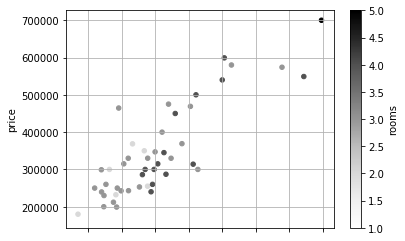

In [256]:
plot1 = data.plot(kind='scatter', x='area', y='price', c='rooms', grid=True)
#plot1.set_facecolor("gray")

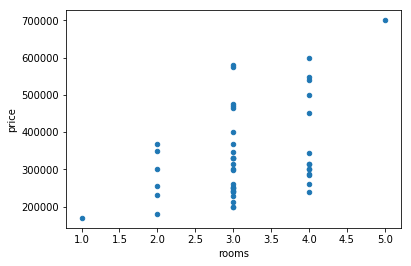

In [257]:
data.plot(kind = 'scatter', x = 'rooms', y='price')

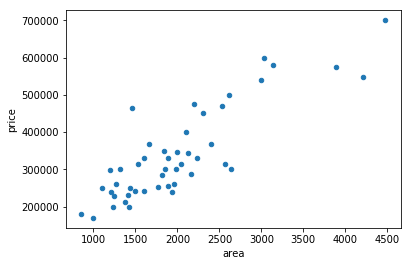

In [258]:
data.plot(kind = 'scatter', x = 'area', y='price')

In [259]:
X = data[['area', 'rooms']]
y = np.array(list(map(float, data['price'])))
#X = StandardScaler().fit_transform(X)
#y = StandardScaler().fit_transform(y.reshape(len(y), 1)).reshape(len(y))
#X = np.append(np.ones(len(X)).reshape((len(X), 1)), X, axis=1)

In [260]:
def standard_transform(x):
    return StandardScaler().fit_transform(x)

def append_one(x):
    return np.append(np.ones(len(x)).reshape((len(x), 1)), x, axis=1)

In [261]:
#X = append_one(standard_transform(X))
scalerX = StandardScaler()
scalerY = StandardScaler()
X = scalerX.fit_transform(X)
X = np.append(np.ones(len(X)).reshape((len(X), 1)), X, axis=1)
print (y)
print (y.reshape(len(y), 1))
y = scalerY.fit_transform(y.reshape(len(y), 1)).reshape(len(y))
# print (y)

[ 399900.  329900.  369000.  232000.  539900.  299900.  314900.  198999.
  212000.  242500.  239999.  347000.  329999.  699900.  259900.  449900.
  299900.  199900.  499998.  599000.  252900.  255000.  242900.  259900.
  573900.  249900.  464500.  469000.  475000.  299900.  349900.  169900.
  314900.  579900.  285900.  249900.  229900.  345000.  549000.  287000.
  368500.  329900.  314000.  299000.  179900.  299900.  239500.]
[[ 399900.]
 [ 329900.]
 [ 369000.]
 [ 232000.]
 [ 539900.]
 [ 299900.]
 [ 314900.]
 [ 198999.]
 [ 212000.]
 [ 242500.]
 [ 239999.]
 [ 347000.]
 [ 329999.]
 [ 699900.]
 [ 259900.]
 [ 449900.]
 [ 299900.]
 [ 199900.]
 [ 499998.]
 [ 599000.]
 [ 252900.]
 [ 255000.]
 [ 242900.]
 [ 259900.]
 [ 573900.]
 [ 249900.]
 [ 464500.]
 [ 469000.]
 [ 475000.]
 [ 299900.]
 [ 349900.]
 [ 169900.]
 [ 314900.]
 [ 579900.]
 [ 285900.]
 [ 249900.]
 [ 229900.]
 [ 345000.]
 [ 549000.]
 [ 287000.]
 [ 368500.]
 [ 329900.]
 [ 314000.]
 [ 299000.]
 [ 179900.]
 [ 299900.]
 [ 239500.]]


In [262]:
#plt.xlabel("Area")
#plt.ylabel("Price")
#plt.plot(X[:, 0], y, 'ro')
#plt.legend(loc = 0)

In [263]:
def get_mse(regressor, xs, ys):    
    predicted = np.apply_along_axis(regressor.predict, 1, xs)
    return ((predicted - ys) ** 2).mean()

def first_price(p):
    print (p)
    return scalerY.inverse_transform(p)[0]

In [280]:
class LinearRegression:
    def __init__(self, w = None, linearCoef = 0.5, numIter = 100):
        self.baseW = w
        self.linearCoef = linearCoef   
        self.numIter = numIter
        
    def _grad_descend(self):
        Xt = X.transpose()
        m = X.shape[0]
        mse = None
        w = self.baseW
        for i in range(self.numIter):
            h = np.dot(X, w)
            diff = h - y
            grad = np.dot(Xt, diff) / m
            mse = (diff ** 2).mean()
            w -= (self.linearCoef[i] * grad)
            
        self.w = w      
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self._grad_descend()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w


In [281]:
m, n = X.shape
w = np.ones(n)
numIter = 1000
linearCoef = [0.1] * numIter
linearReg = LinearRegression(w = w, linearCoef = linearCoef, numIter = numIter)
#print (kf_cross_validation(linearReg, X_learn, y_learn))
linearReg.fit(X, y)
print (get_mse(linearReg, X, y))
print (linearReg.weights())

0.267054981971
[ -8.42710394e-17   8.84765988e-01  -5.31788197e-02]


In [282]:
def show_separator(weights):
    for i, x in enumerate(X.transpose()[1:], 1):
        plt.scatter(x, y)
        plt.plot([x.min(), x.max()], [weights[0] + weights[i] * x.min(), weights[0] + weights[i] * x.max()])      
        plt.ylabel('Scaled price')
        plt.xlabel('Scaled %s' % ['area', 'rooms'][i-1])
        plt.show()

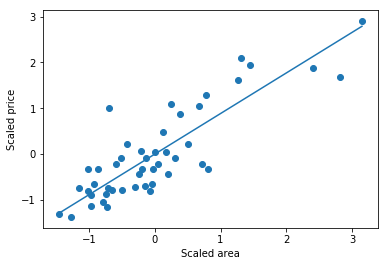

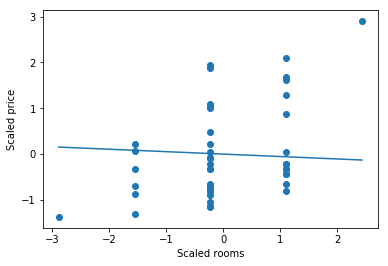

In [283]:
linW = linearReg.weights()
show_separator(linW)

In [287]:
np.random.seed(53)

def mutation(pop):
    return pop + randn(*pop.shape)

class GeneticReg:
    def __init__(self, numIter = 100, popSize = 10, mutationCount = 5):        
        self.numIter = numIter
        self.popSize = popSize
        self.mutationCount = mutationCount
    
    def gen_optimize(self):
        m, n = self.X.shape
        pop = np.zeros((self.popSize, n))
        pops = []
        mses = []        
       
        for i in range(numIter):
            pops = pop.copy()
            for j in range(self.mutationCount):
                pops = np.append(pops, mutation(pop), axis=0)
                        
            mses = []
            for j, single_pop in enumerate(pops):
                h = np.dot(X, single_pop)
                diff = h - y
                mse = (diff ** 2).mean()
                mses.append((mse, j))
            mses = sorted(mses)
            pop = pops[mses[0][1]].reshape(1, len(pops[mses[0][1]]))
            if (mses[0][0] < 0.2):
                break
            for _, j in mses[1:self.popSize]:
                pop = np.append(pop, pops[j].reshape(1, len(pops[j])), axis=0)                                    
        
        self.w = pops[mses[0][1]]
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self.gen_optimize()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w

In [288]:
genReg = GeneticReg()
genReg.fit(X, y)
print (get_mse(genReg, X, y))
print (genReg.weights())

0.268836197635
[ -9.70076036e-06   8.34965832e-01  -1.64146213e-02]


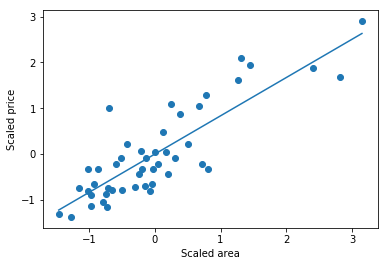

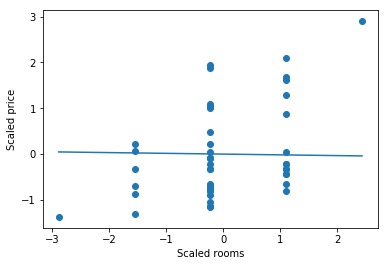

In [289]:
genW = genReg.weights()
show_separator(genW)

In [241]:
exX = [[2100., 3.]]
exX = append_one(scalerX.transform(exX))

print (first_price(linearReg.predict(exX)))
print (first_price(genReg.predict(exX)))

[ 0.12379381]
355726.267643
[ 0.10918083]
353918.604942
